# Introduction

In this Jupyter notebook, we will embark on an exploration of the intriguing field of **electrocardiogram (ECG)** signal processing and classification, utilizing the capabilities of a **Convolutional Neural Network (CNN) Autoencoder**. Our chosen dataset for this journey is the PTB Diagnostic ECG Database, a meticulously curated collection of ECG signals crafted explicitly for diagnostic purposes. Our primary objective is to construct a robust Autoencoder model tailored for the task of detecting anomalous electrocardiogram (ECG) signals.

## Dataset Overview

The **PTB Diagnostic ECG Database** is a collection of 14,552 ECG recordings sourced from Physionet's PTB Diagnostic Database. These ECG signals are categorized into two classes: normal heartbeats and those affected by cardiac abnormalities. The dataset is sampled at 125Hz, providing high-resolution data for in-depth analysis.

> Let's delve into some essential details about the PTB Diagnostic ECG Database:
> 
> - **Number of Samples:** 14,552
> - **Number of Categories:** 2
> - **Sampling Frequency:** 125Hz
> - **Data Source:** Physionet's PTB Diagnostic Database

In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[]

In [26]:
normal_df = pd.read_csv("../data/ptbdb_normal.csv",header=None).iloc[:,:-1]
normal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
anomally_df = pd.read_csv("../data/ptbdb_abnormal.csv",header=None).iloc[:,:-1]
anomally_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

In [27]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomally_df.shape)

Shape of Normal data (4046, 187)
Shape of Abnormal data (10506, 187)


In [28]:
normal_df.iloc[0]

0      1.000000
1      0.900324
2      0.358590
3      0.051459
4      0.046596
         ...   
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: 0, Length: 187, dtype: float64

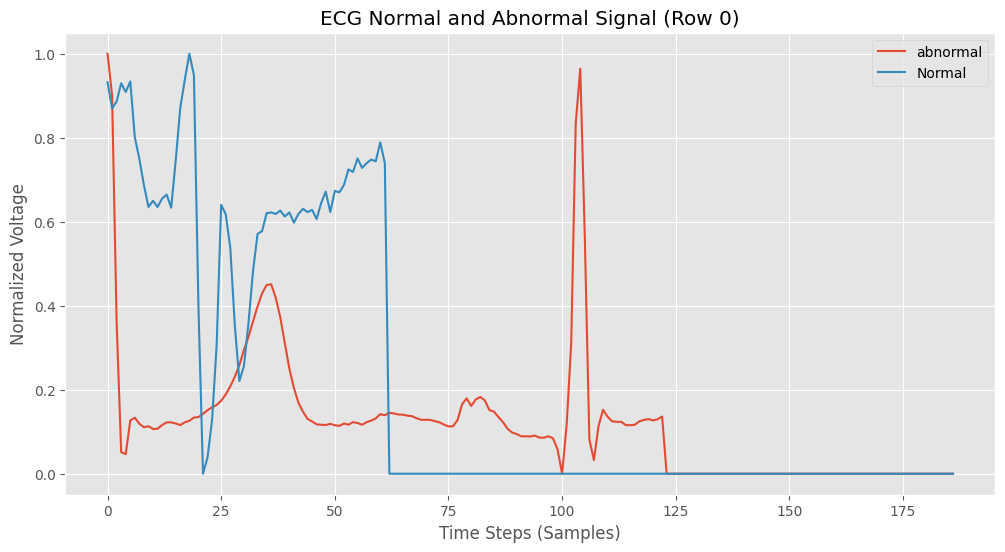

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(normal_df.iloc[0], label = "abnormal")
plt.plot(anomally_df.iloc[0], label = "Normal")


plt.legend()
plt.title(f"ECG Normal and Abnormal Signal (Row {0})")
plt.xlabel("Time Steps (Samples)")
plt.ylabel("Normalized Voltage")
plt.grid(True)
plt.show()

The code below generates a visual comparison between two randomly selected ECG signal samples: one from the "Normal" dataset and the other from the "Anomaly" dataset. This side-by-side plot enables a direct visual assessment of ECG signal patterns between normal and anomalous cases.

In [22]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)
    
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")
    
    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Anomaly")
    
    plt.tight_layout()
    plt.show()

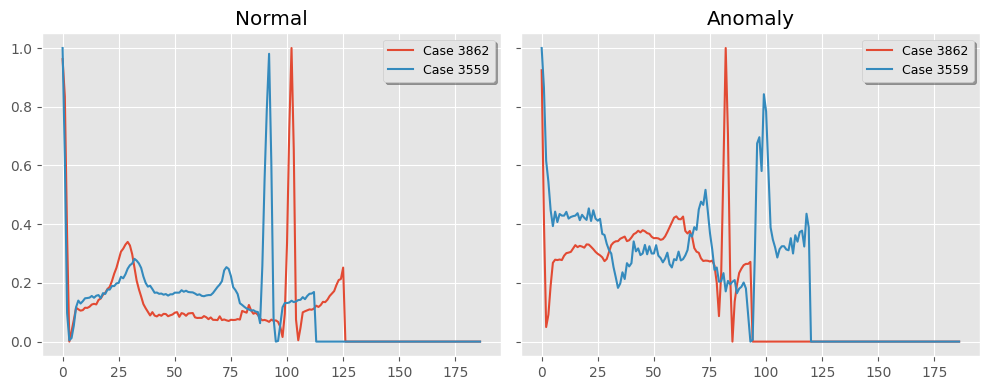

In [30]:
plot_sample(normal_df, anomally_df)

In [31]:
CLASS_NAMES = ["Normal", "Anomaly"]

normal_df_copy = normal_df.copy()
anomaly_df_copy = anomally_df.copy()
print(anomaly_df_copy.columns.equals(normal_df_copy.columns))

True


In [32]:
normal_df.shape

(4046, 187)

In [33]:
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
anomaly_df_copy = anomaly_df_copy.assign(target = CLASS_NAMES[1])

In [35]:
normal_df_copy.shape

(4046, 188)

In [36]:
anomaly_df_copy.shape

(10506, 188)

In [37]:
df = pd.concat((normal_df_copy, anomaly_df_copy))

In [40]:
df.shape

(14552, 188)

In [41]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,target
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


## Smoothed Mean Plot for Class Comparison

In this Python code, a function called `plot_smoothed_mean` is defined for creating smoothed mean plots. It takes input data, a class name, and a step size as parameters. The function calculates the rolling mean and standard deviation of the data with the specified step size, then plots the smoothed mean along with a shaded area representing the margin of three times the standard deviation.

The code also demonstrates the use of this function to compare the smoothed means of different classes. It creates a subplot with two panels, each representing a different class. The data for each class is grouped, and the mean is computed before passing it to the `plot_smoothed_mean` function. This allows for visualizing how the smoothed means of different classes compare.

The resulting plot provides insights into how the means of different classes vary over time or some other variable represented by the data, with shaded areas indicating the uncertainty around the mean estimates.y

In [44]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

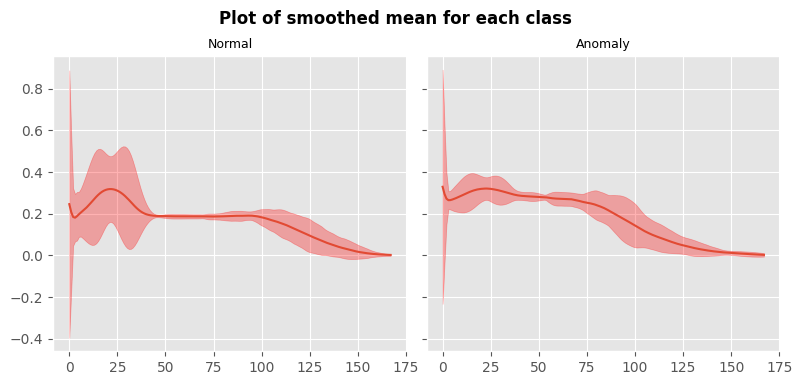

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

In [47]:
df.to_csv('../data/prepared_data.csv')
print("Data successfully saved to prepared_data.csv")

Data successfully saved to prepared_data.csv
